## Events Analysis

This notebook looks at changes around major U.S. events: 9/11, the 2008 Financial Crisis, and the 2016 election.

### Import packages and load data

In [22]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import nltk
import seaborn as sns

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

from ast import literal_eval
import source.helper_functions as helper


In [2]:
# load corpus
file = '../tal-scrape/total_trans_normalized.csv'
tal_df = pd.read_csv(file, converters = helper.converters)

In [3]:
tal_df.head()

,ep_num,ep_title,year,url,act_name,text,tokenized_sents,no_lemma_normalized_sents,normalized_sents,tokenized_text,normalized_tokens,no_lemma_normalized_tokens
0,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Four: Act Four,This is Your Radio Playhouse. I'm Ira Glass. O...,"[[This, is, Your, Radio, Playhouse], [I, 'm, I...","[[radio, playhouse], [m, ira, glass], [ok, rig...","[[radio, playhouse], [be, ira, glass], [okay, ...","[This, is, Your, Radio, Playhouse, I, 'm, Ira,...","[radio, playhouse, be, ira, glass, okay, right...","[radio, playhouse, m, ira, glass, ok, right, r..."
1,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Three: Act Three,"Well, next on our little playhouse stage, we h...","[[Well, next, on, our, little, playhouse, stag...","[[little, playhouse, stage, mr, lawrence, steg...","[[little, playhouse, stage, mr, lawrence, steg...","[Well, next, on, our, little, playhouse, stage...","[little, playhouse, stage, mr, lawrence, stege...","[little, playhouse, stage, mr, lawrence, stege..."
2,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Two: Act Two,"Good morning. Glass, Jacobson & Associates.Hey...","[[Good, morning], [Glass, Jacobson, Associates...","[[good, morning], [glass, jacobson, associates...","[[good, morning], [glass, jacobson, associate]...","[Good, morning, Glass, Jacobson, Associates, H...","[good, morning, glass, jacobson, associate, he...","[good, morning, glass, jacobson, associates, h..."
3,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act One: Act One,"All right, Your Radio Playhouse. All right. I'...","[[All, right, Your, Radio, Playhouse], [All, r...","[[right, radio, playhouse], [right], [m, makin...","[[right, radio, playhouse], [right], [be, make...","[All, right, Your, Radio, Playhouse, All, righ...","[right, radio, playhouse, right, be, make, eye...","[right, radio, playhouse, right, m, making, ey..."
4,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Prologue,"Joe Franklin?I'm ready.It's Ira Glass here.Oh,...","[[Joe, Franklin?I'm, ready], [It, 's, Ira, Gla...","[[joe, franklin?i'm, ready], [ira, glass], [oh...","[[joe, franklin?i'm, ready], [ira, glass], [oh...","[Joe, Franklin?I'm, ready, It, 's, Ira, Glass,...","[joe, franklin?i'm, ready, ira, glass, oh, emc...","[joe, franklin?i'm, ready, ira, glass, oh, emc..."


### Event 1: 9/11

In [4]:
# words of interest for this event
word1 = ['iraq', 'iraqi', 'iraqis', 'afghanistan', 'qaeda', 'weapon', 'weapons', 'muslim', 'muslims', 
         'terrorist', 'terrorism', 'terror', 'panic', 'war', 'hate', 'soldier', 'soldiers', 
         'ally', 'allies', 'security', 'secure']
word2 = ['love', 'america', 'american', 'country', 'safe', 'family', 'home']

#### First, I will examine collocations.

I will focus on comparing collocations of certain words in each of the three years before 2001 (i.e. 1998,1999,2000). Then I will look at colocations in the year of the event and the two years after (2001,2002,2003)

In [5]:
# prep text
df98 = tal_df[tal_df.year==1998]
df99 = tal_df[tal_df.year==1999]
df00 = tal_df[tal_df.year==2000]
df01 = tal_df[tal_df.year==2001]
df02 = tal_df[tal_df.year==2002]
df03 = tal_df[tal_df.year==2003]

In [96]:
def get_text_collocation(df):
    return nltk.Text(df.no_lemma_normalized_tokens.sum())

def get_concordance(text, word):
    index = nltk.text.ConcordanceIndex(text)
    return index.print_concordance(word)

def get_context(text, words):
    return text.common_contexts(words)

def get_count(text,word):
    return text.count(word)

def plot_count(full_df, years, word):
    # counts
    years = sorted(years)
    counts = []
    for y in years:
        tmp = full_df[full_df.year==y]
        text = get_text_collocation(tmp)
        c = get_count(text,word)
        counts.append(c)
    sns.lineplot(x=years, y=counts)
    plt.title('Frequency of {} in TAL'.format(word))
    plt.show()

def print_collocation(df, wordlist, concordance=False, context=True):
    text = get_text_collocation(df)
    
    for w in wordlist:
        print('Word: {}'.format(w))
        if concordance:
            print('Concordance: ')
            get_concordance(text, w)
            print()
        if context:
            print('Common context: ')
            get_context(text, [w])
        print()
        print()
        
def plot_dispersion(df,wordlist):
    text = get_text_collocation(df)
    sns.reset_orig() #Seaborn messes with this plot, disabling it
    text.dispersion_plot(wordlist)
    sns.set() #Re-enabling seaborn

### 1998

In [73]:
helper.print_collocation(df98, word1)

Word: iraq
Common context: 
('The following word(s) were not found:', 'iraq')


Word: iraqi
Common context: 
('The following word(s) were not found:', 'iraqi')


Word: iraqis
Common context: 
('The following word(s) were not found:', 'iraqis')


Word: afghanistan
Common context: 
landing_called


Word: qaeda
Common context: 
('The following word(s) were not found:', 'qaeda')


Word: weapon
Common context: 
head_small nuclear_deposited poked_anders


Word: weapons
Common context: 
('The following word(s) were not found:', 'weapons')


Word: muslim
Common context: 
('The following word(s) were not found:', 'muslim')


Word: muslims
Common context: 
('The following word(s) were not found:', 'muslims')


Word: terrorist
Common context: 
('The following word(s) were not found:', 'terrorist')


Word: terrorism
Common context: 
('The following word(s) were not found:', 'terrorism')


Word: terror
Common context: 
represented_life got_falls got_water cry_father trilogy_gets
tears_loss tv_news


In [74]:
helper.print_collocation(df98, word2)

Word: home
Common context: 
living_mom songs_actually went_exercise come_throw come_business
coming_hanging come_kind came_slept driving_blue rode_seat drove_blue
work_spotting bus_courage come_honey bringing_second come_smoke
comes_day time_got went_today come_listen


Word: family
Common context: 
red?my_understand right_love typical_thing fat_scale parents_phone
conferences_going taking_soon mexican_married outcast_m oldest_find
wants_like vacations_unhappy relationship_suffered cast_needed
scratch_job margy_families sex_kind sex_little came_laura sister_dish


Word: safe
Common context: 
little_holding drive_bring rules_puts fairly_rockets stay_possible
volunteer_place pray_trip ensure_passage decline_happy felt_letting
feel_m concern_yeah verbalize_let unusually_bubble living_little
thoroughly_unfortunately cider_said saying_drink twice_hazardous
produce_cider


Word: country
Common context: 
leaving_brings washington_melamid landscape_want want_holland
beautiful_museum opposite_b

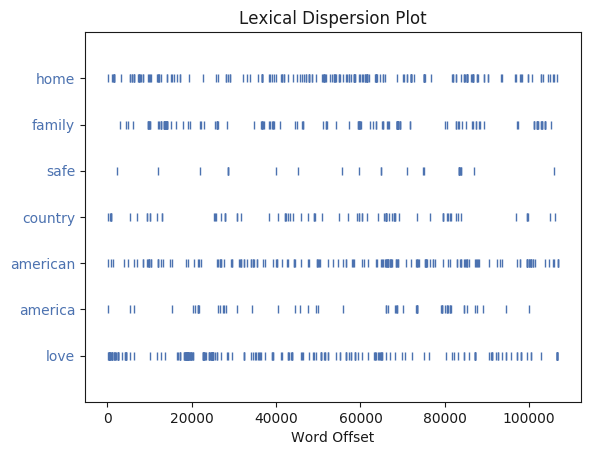

In [76]:
helper.plot_dispersion(text, word2)

## Individual years 

Which should we focus on? Definitely see some expected trends that are quantified here. (Muslim doesn't even really show up until 2001). 

### 1999

Word: iraq
Common context: 
('The following word(s) were not found:', 'iraq')


Word: iraqi
Common context: 
('The following word(s) were not found:', 'iraqi')


Word: iraqis
Common context: 
('The following word(s) were not found:', 'iraqis')


Word: afghanistan
Common context: 
refugee_today


Word: qaeda
Common context: 
('The following word(s) were not found:', 'qaeda')


Word: weapon
Common context: 
coming_thought


Word: weapons
Common context: 
main_alcohol thing_phone believe_involved


Word: muslim
Common context: 
jealously_authorities grown_country


Word: muslims
Common context: 
sites_believe


Word: terrorist
Common context: 
albino_act like_bases


Word: terrorism
Common context: 
treason_framed


Word: terror
Common context: 
dad_alive signs_try release_torial element_times live_father
event_mounted apartment_targeted family_horror grandeur_fact


Word: panic
Common context: 
private_found bit_factor god_starting primary_having secondary_knowing
tertiary_realizing feel

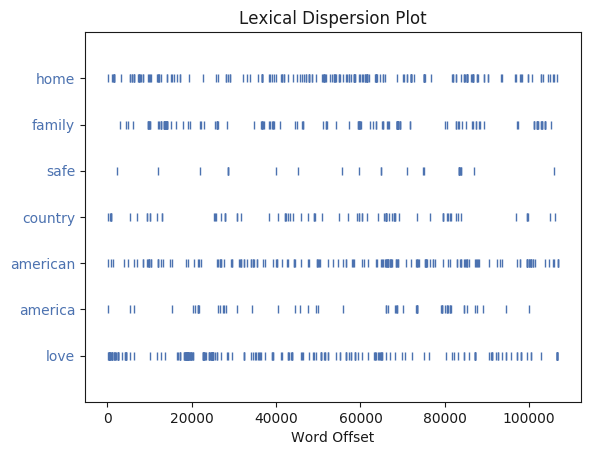

In [78]:
helper.print_collocation(df99, word1)

helper.print_collocation(df99, word2)

helper.plot_dispersion(text, word2)

### 2000

Word: iraq
Common context: 
('The following word(s) were not found:', 'iraq')


Word: iraqi
Common context: 
('The following word(s) were not found:', 'iraqi')


Word: iraqis
Common context: 
('The following word(s) were not found:', 'iraqis')


Word: afghanistan
Common context: 
('The following word(s) were not found:', 'afghanistan')


Word: qaeda
Common context: 
('The following word(s) were not found:', 'qaeda')


Word: weapon
Common context: 
older_ai


Word: weapons
Common context: 
('The following word(s) were not found:', 'weapons')


Word: muslim
Common context: 
('The following word(s) were not found:', 'muslim')


Word: muslims
Common context: 
('The following word(s) were not found:', 'muslims')


Word: terrorist
Common context: 
('The following word(s) were not found:', 'terrorist')


Word: terrorism
Common context: 
('The following word(s) were not found:', 'terrorism')


Word: terror
Common context: 
striking_edith ground_lightning mob_mob fear_firsthand


Word: panic
Co

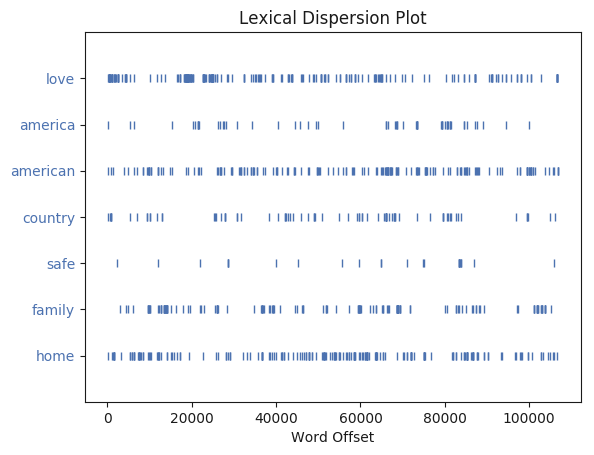

In [79]:
helper.print_collocation(df00, word1)

helper.print_collocation(df00, word2)

helper.plot_dispersion(text, word2)

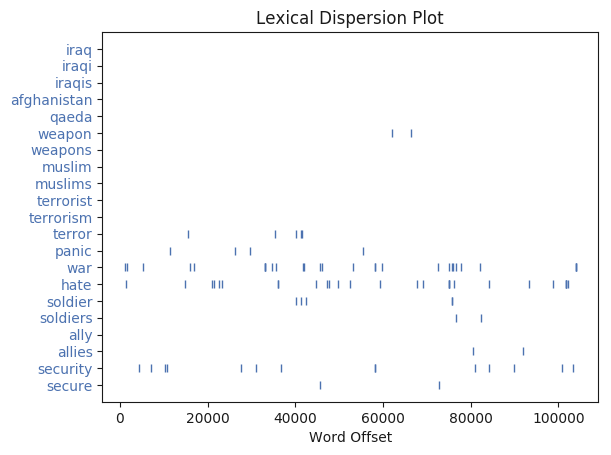

In [93]:
helper.plot_dispersion(df00,word1)

### 2001

In [95]:
helper.print_collocation(df01, word1)

helper.print_collocation(df01, word2)

helper.plot_dispersion(text, word2)

Word: secure
Common context: 
flight--_doors cicero_chicago head_folks


Word: security
Common context: 
like_feel information_person annoying_floodlights inside_alarm
response_grab dogs_proper social_rest heavy_line national_archive
nations_council


Word: allies
Common context: 
bush_showed fall_acknowledged surrender_changed history_routinely


Word: ally
Common context: 
wear_sheedy strong_west


Word: soldiers
Common context: 
twin_command killed_says killed_fired whim_like ordinary_giving
battle_sides faces_standing pakistani_un american_killed
american_involved young_trained american_allowed trained_world
american_certainly israeli_shooting government_suddenly lots_found
visit_stationed tank_gather numbers_messages


Word: soldier
Common context: 
affection_lap lap_lap lap_come come_quickly japanese_viking dead_ruins
israeli_checkpoint


Word: hate
Common context: 
supreme_supreme want_says heaven_person know_rochester his--_this--
bosses_hate hate_found things_horrifying julie_

AttributeError: 'Text' object has no attribute 'no_lemma_normalized_tokens'

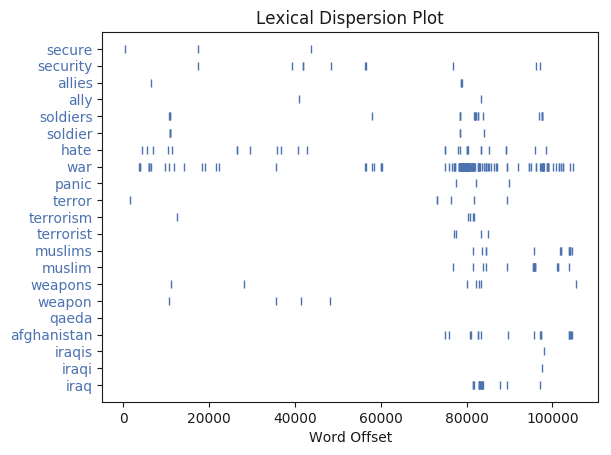

In [88]:
helper.plot_dispersion(df01,word1)

### 2002

Word: iraq
Common context: 
iran_pa deployed_afghanistan danger_posed war_priority war_yes
issue_ira war_public war_justified going_ways war_likely war_ve
point_links qaeda_breaking war_actually focus_expense war_think
comes_realists believe_weapons iran_war helping_weak


Word: iraqi
Common context: 
happening_forces processed_prisoners hear_soldier overthrow_regime
communicated_foreign heeded_officials oil_oil hear_perspectives
hundreds_refugees lot_run years_army power_army america_army--
defend_soldiers life_army buy_poor 18-ish_guys different_neighborhood
day_embassy poor_neighborhood


Word: iraqis
Common context: 
threat_heeded speeches_ve including_close population_come filled_cars
look_look ask_think tells_knows things_usually person_desperate
turn_invite talking_hearing


Word: afghanistan
Common context: 
fighting_today troops_alex operations_incredibly bomb_minute iraq_war
missions_monitoring like_look fly_fly win_find


Word: qaeda
Common context: 
al_nautical al_iraq al_d

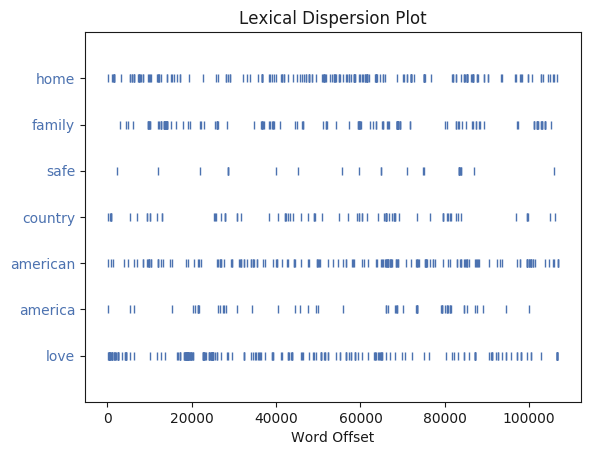

In [82]:
helper.print_collocation(df02, word1)

helper.print_collocation(df02, word2)

helper.plot_dispersion(text, word2)

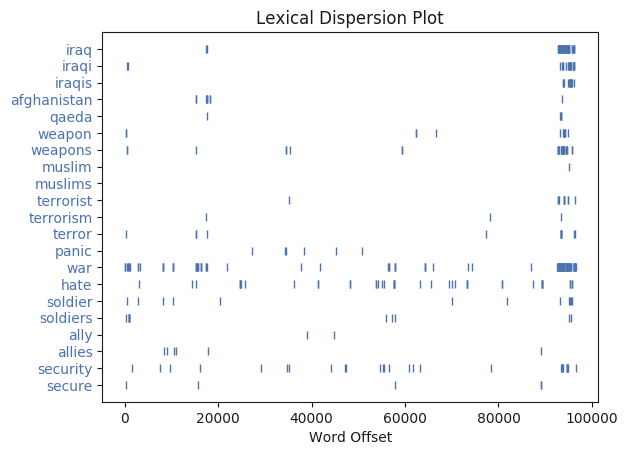

In [89]:
helper.plot_dispersion(df02,word1)

### 2003

Word: iraq
Common context: 
fly_lands kuwait_iraqi transjordan_invade happen_maybe reason_middle
people_pakistan baghdad_joe war_europe shift_placed iran_war?yes
range_chemical government_right campaign_right happened_afghanistan
liberate_saddam people_doubted going_probably far_story war_largest
war_long


Word: iraqi
Common context: 
men_soldiers gas_kurds wait_army dropped_forces iraq_air bleep_hear
rpgs_soldiers number_deaths operation_freedom heard_soldiers
spoke_named smiling_army kennedy_army burning_currency $_photo
lot_newspapers young_girl mind_suffering solidarity_people
smuggled_named


Word: iraqis
Common context: 
iran_experts wonder_preparing annihilate_shirts chance_drop
near_competent platoon_appears surrendering_remains shoot_spend
dead_surrounding crushing_sleep let_seventh find_persuade freedom_want
gap_americans gotten_agency cpa_know want_poor pages_general
general_know group_speak


Word: afghanistan
Common context: 
pakistan_according captured_padilla battle_ene

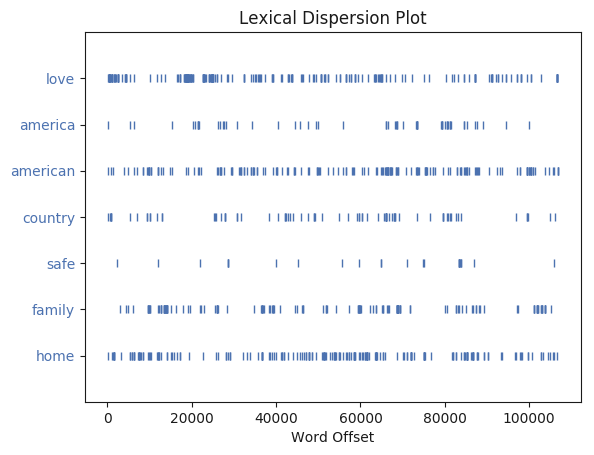

In [83]:
helper.print_collocation(df03, word1)

helper.print_collocation(df03, word2)

helper.plot_dispersion(text, word2)

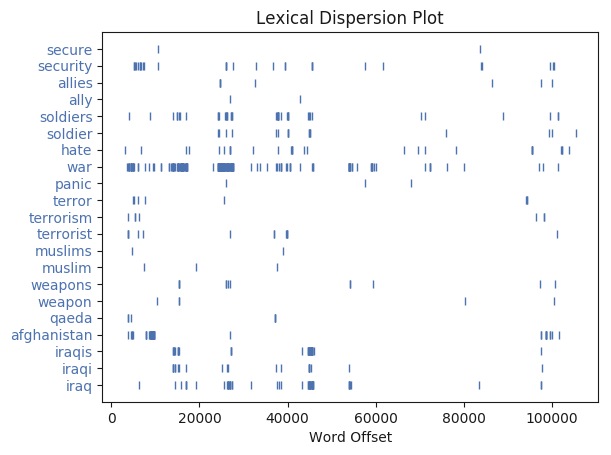

In [90]:
helper.plot_dispersion(df03,word1)

## Aggregate over the years

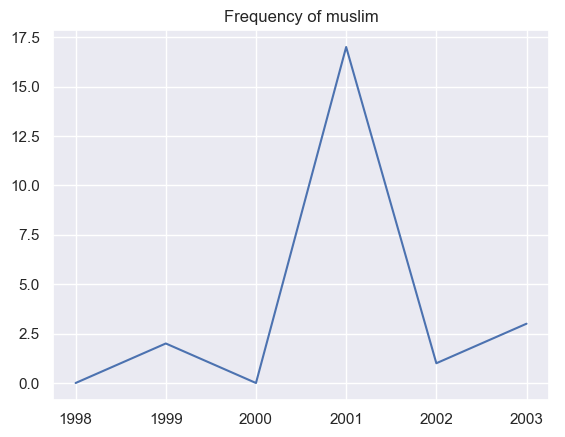

In [100]:
# frequency of word
plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'muslim')

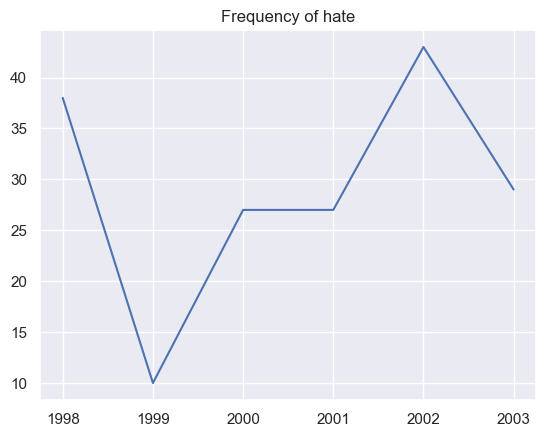

In [101]:
plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'hate')

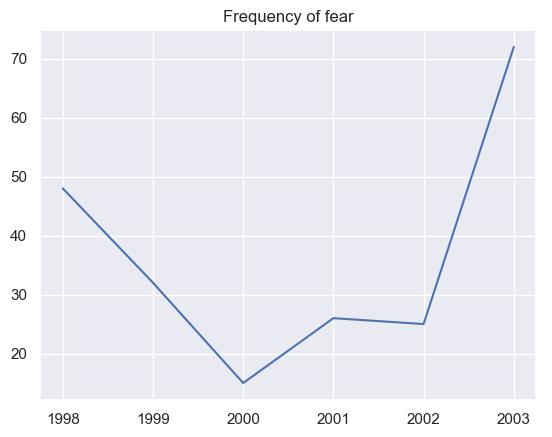

In [103]:
plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'fear')